In [1]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from statistics import mean

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import math
import copy
from torch.distributions import Categorical
from gym.wrappers import Monitor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Hyper-parameters
solved_reward = 30           # stop training if avg_reward > solved_reward
log_interval = 100           # print avg reward in the interval
max_episodes = 1000          # max training episodes
max_timesteps = 500          # max timesteps in one episode
n_latent_var = 64            # number of variables in hidden layer
update_timestep = 2000       # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.01                # discount factor
K_epochs = 1                 # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO
random_seed = None
render = False
epsilon = 0.2                #need to change it to max(advantage)
dkl=1                       #need to change it to KL divergence between old and new policies
Q_r=[]
Q_r1=[]
a=[]

In [6]:
env_name = "LunarLander-v2"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n      #shape[0]
print("State Dimension : ", state_dim, "Action Dimension :", action_dim)

State Dimension :  8 Action Dimension : 4


In [7]:
Q=np.zeros((max_timesteps,action_dim))

In [8]:
class GeneticAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(state_dim,128, bias=True),
                        nn.ReLU(),
                        nn.Linear(128,action_dim, bias=True),
                        nn.Softmax(dim=1)
                        )

                
        def forward(self, inputs):
            x = self.fc(inputs)
            return x

In [9]:
def init_weights(m):
    
        # nn.Conv2d weights are of shape [16, 1, 3, 3] i.e. # number of filters, 1, stride, stride
        # nn.Conv2d bias is of shape [16] i.e. # number of filters
        
        # nn.Linear weights are of shape [32, 24336] i.e. # number of input features, number of output features
        # nn.Linear bias is of shape [32] i.e. # number of output features
        
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.00)

In [10]:
def behavioural_policy(agents):
    return agent

In [11]:
def KL_divergence(agent1,agent2):
    return KL

In [12]:
def return_random_agents(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = GeneticAI()
        
        for param in agent.parameters():
            param.requires_grad = False
            
        init_weights(agent)
        agents.append(agent)
        
        
    return agents

In [13]:
def run_agents(agents):
    
    surrogate_agents = []
    env = gym.make(env_name)
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        a.clear()
        Q_r1.clear()
        Q_r.clear()
        for i in range(max_timesteps):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            #print(output_probabilities)
            for j in range(0, action_dim):
                Q[i][j]=output_probabilities[j]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            a.append(action)
            new_observation, reward, done, info = env.step(action)
            r+=reward
            Q_r.append(r)
            observation = new_observation
            if(done):
                break

        surrogate_agents.append(r)
        #surrogate_agents.append(s)
        d_r=0
        #print("Non-discounted Reward:::",Q_r)
        for rew in reversed(Q_r):
            if rew==Q_r[len(Q_r)-1]:
                d_r=0
            else:
                d_r=rew+gamma*d_r
            Q_r1.insert(0,d_r)
            
        
    #print("Exit")
    #Q=Q[~np.all(Q==0,axis=1)]
    #print("Reward:::",surrogate_agents)
    #print("Probabilities:::",Q)
    #print("Actions:::",a)
    #print("Discounted Reward,i.e,Q:::",Q_r1)
    
    
    return surrogate_agents

In [14]:
def run_target_agents(agents):
    
    surrogate_agents = []
    env = gym.make(env_name)
    #print("Enter")
    for agent in agents:#There is only one agent in the list. But it is necessary to pass the agents in the form of lists to make it iterable and work on it
        agent.eval()
        #print("HELLLO!!!!!!")
        observation = env.reset()
        r=0
        s=0
        i=0
        #print("SIZE OF ACTIONS:",len(a),"SIZE OF PROBABILITIES:",Q.shape,"SIZE OF DISCOUNTED REWARDS:",len(Q_r1))
        for i in range(len(Q_r1)-1):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            L_pi=(output_probabilities[a[i]]/Q[i][a[i]])*Q_r1[i]
            #print("L_pi",L_pi)
            #surr1= L_pi-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
            
            #print(output_probabilities)
            s+=L_pi
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env.step(action)
            #r+=(gamma**i)*reward
            
            #s=s+1
            observation = new_observation

            if(done):
                break
        #print("S:",s)
        #print("Max Q_r1:",max(Q_r1))
        surr1= s-(4*max(Q_r1)*gamma*dkl/np.square(1-gamma))
        #print("Surr1:",surr1)
        surrogate_agents.append(surr1)        
        #surrogate_agents.append(s)
    #print("Exit")
    #print("REWARD AGENTS",surrogate_agents)
    #print(surrogate_agents)
    return surrogate_agents

In [15]:
def alternate_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_target_agents([agent])[0]
    return score/runs

In [16]:
def return_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_agents([agent])[0]
    return score/runs

In [17]:
def run_agents_n_times(agents, runs):
    avg_score = []
    for agent in agents:
        if agent==agents[0]:
            avg_score.append(return_average_score(agent,runs))
        else:
            avg_score.append(alternate_average_score(agent,runs))
    return avg_score

In [18]:
def mutate(agent):

    child_agent = copy.deepcopy(agent)
    
    mutation_power = 0.02 #hyper-parameter, set from https://arxiv.org/pdf/1712.06567.pdf
            
    for param in child_agent.parameters():
    
        if(len(param.shape)==4): #weights of Conv2D

            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    for i2 in range(param.shape[2]):
                        for i3 in range(param.shape[3]):
                            
                            param[i0][i1][i2][i3]+= mutation_power * np.random.randn()
                                
                                    

        elif(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    
                    param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                
                param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [19]:
def return_children(agents, sorted_parent_indexes, elite_index):
    
    children_agents = []
    
    #first take selected parents from sorted_parent_indexes and generate N-1 children
    for i in range(len(agents)-1):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        children_agents.append(mutate(agents[selected_agent_index]))

    #now add one elite
    elite_child = add_elite(agents, sorted_parent_indexes, elite_index)
    children_agents.append(elite_child)
    elite_index=len(children_agents)-1 #it is the last one
    
    return children_agents, elite_index

In [20]:
def add_elite(agents, sorted_parent_indexes, elite_index=None, only_consider_top_n=10):
    
    candidate_elite_index = sorted_parent_indexes[:only_consider_top_n]
    
    if(elite_index is not None):
        candidate_elite_index = np.append(candidate_elite_index,[elite_index])
        
    top_score = None
    top_elite_index = None
    
    for i in candidate_elite_index:
        score = return_average_score(agents[i],runs=5)
        print("Score for elite i ", i, " is ", score)
        
        if(top_score is None):
            top_score = score
            top_elite_index = i
        elif(score > top_score):
            top_score = score
            top_elite_index = i
            
    print("Elite selected with index ",top_elite_index, " and score", top_score)
    
    child_agent = copy.deepcopy(agents[top_elite_index])
    return child_agent

In [21]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

C:\Users\Chirag\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))




Generation  0  | Mean surrogate:  -309.624217112129  | Mean of top 5:  -206.862477561907
Top  20  scores [  0 132 411 455 466 257 312 220 379  66 443 163  54 355 100  91  88  99
 190  36]
surrogate for top:  [-96.7613023498267, -233.37359578717283, -233.63863380538723, -235.14939803271426, -235.38945783443415, -236.23435388857197, -236.72460825891997, -236.78514827807976, -237.35363722010334, -237.40900413817178, -238.25630947614934, -239.48413441782665, -239.60568656151904, -239.68464554789023, -239.71478329289863, -240.16885313194177, -241.47145975947197, -244.48238596510555, -245.57742483971975, -245.60769134321896]
Score for elite i  0  is  -153.14424547792865
Score for elite i  132  is  -248.7121767536416
Score for elite i  411  is  -385.2476300059425
Score for elite i  455  is  -215.68293496457926
Score for elite i  466  is  -95.56300026625397
Score for elite i  257  is  -214.15972650543978
Score for elite i  312  is  -210.49962860010137
Score for elite i  220  is  -139.2127409

Score for elite i  101  is  -222.67399315913
Score for elite i  499  is  -264.5623946103466
Elite selected with index  192  and score -136.42855065121756


Generation  7  | Mean surrogate:  -4432.802124935273  | Mean of top 5:  -1212.986763977156
Top  20  scores [  0 374 348  45 330 382 176 289 256  25 236 188 434 182 319 199 276 298
 481 355]
surrogate for top:  [-329.3813116087082, -1369.8252134511313, -1439.920571466296, -1445.1154464194879, -1480.6912769401565, -1520.6811041426415, -1561.444464834777, -1577.252958012833, -1584.7551075263837, -1590.5901737847505, -1616.5631872191673, -1618.3493862470625, -1621.127664886877, -1629.0054418053517, -1632.4716903406193, -1655.60018307178, -1665.8062207445282, -1688.1075501896244, -1696.9806643244824, -1716.8566650308228]
Score for elite i  0  is  -256.89045943590276
Score for elite i  374  is  -244.00800221757044
Score for elite i  348  is  -159.46611084204477
Score for elite i  45  is  -207.24262258668335
Score for elite i  330  is  -17

Score for elite i  497  is  -133.2700382639772
Score for elite i  87  is  -205.05555241859437
Score for elite i  60  is  -336.9980516179283
Score for elite i  418  is  -195.46748378373348
Score for elite i  499  is  -271.7037629048181
Elite selected with index  497  and score -133.2700382639772


Generation  14  | Mean surrogate:  -2739.918841096353  | Mean of top 5:  -1610.4363522449185
Top  20  scores [  0 419 349 153 132 104  44 386 344 367 191 317  28 414 405 252  75 476
 137 324]
surrogate for top:  [-121.88971463334592, -1942.5660678068355, -1982.4792336413793, -1988.3884519903625, -2016.8582931526691, -2022.154011358002, -2062.5719956547, -2068.560187748243, -2074.876442007699, -2087.8912266648344, -2096.4601679384928, -2100.759693951939, -2113.451628261253, -2127.4846402603225, -2133.0185545460677, -2139.73587022162, -2148.7565547709237, -2157.4188828337547, -2172.9171709993175, -2174.7394959999237]
Score for elite i  0  is  -262.25635640188136
Score for elite i  419  is  -310.

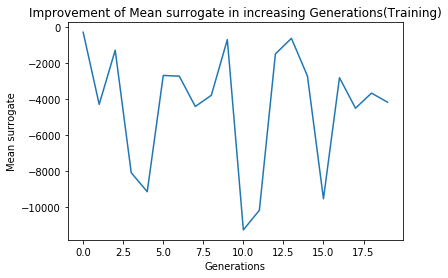

In [22]:
game_actions = action_dim #2 actions possible: left or right

#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 500
agents = return_random_agents(num_agents)

# How many top agents to consider as parents
top_limit = 20

# run evolution until X generations
generations = 20

elite_index = None
n=[]
m = []

for generation in range(generations):

    # return surrogate of agents
    surrogate = run_agents_n_times(agents, 1) #return average of 3 runs later
    #print(surrogate)
    #sort by surrogate
    sorted_parent_indexes = np.argsort(surrogate)[::-1][:top_limit] #reverses and gives top values (argsort sorts by ascending by default) https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    print("")
    print("")
    top_surrogate = []
    
    for best_parent in sorted_parent_indexes:
        top_surrogate.append(surrogate[best_parent])
    
    print("Generation ", generation, " | Mean surrogate: ", np.mean(surrogate), " | Mean of top 5: ",np.mean(top_surrogate[:5]))
    #print(surrogate)
    print("Top ",top_limit," scores", sorted_parent_indexes)
    print("surrogate for top: ",top_surrogate)
    
    m.append(np.mean(top_surrogate[:5])) 
    n.append(np.mean(surrogate))
    
    # setup an empty list for containing children agents
    children_agents, elite_index = return_children(agents, sorted_parent_indexes, elite_index)

    # kill all agents, and replace them with their children
    agents = children_agents
x=np.arange(generations)
plt.plot(x,n)
plt.title('Improvement of Mean surrogate in increasing Generations(Training)')
plt.ylabel('Mean surrogate')
plt.xlabel('Generations')
plt.show()

In [ ]:
def play_agent(agent):
        env = gym.make(env_name)
        
        env_record = Monitor(env, './video', force=True)
        observation = env_record.reset()
        last_observation = observation
        r=0
        j=[]
        episode_durations=[]
        timestep=0
        for timestep in range(250):
            env_record.render()
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env_record.step(action)
            r=r+reward
            j.append(r)
            observation = new_observation

            if(done):
                break

        env_record.close()

        print("Rewards: ",r)

In [ ]:
play_agent(agents[0])